In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [9]:
# 1. Load Data
df = pd.read_csv("5000_cleaned_combined2.csv")

In [10]:
# 2. Encode label (multi-class)
le = LabelEncoder()
y = le.fit_transform(df['label'])
X_text = df['cleaned_content']

In [11]:
# 3. TF-IDF vectorization (max_features=5000)
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X_text)

In [12]:
count = df['label'].value_counts()
print("Jumlah data per label:")
for label, count in count.items():
    print(f"{label}: {count}")

Jumlah data per label:
easeofuse: 1214
reliability: 1041
nonquality: 853
informationquality: 773
responsiveness: 647
webdesign: 306
privacy: 166


In [13]:
# 4. K-Fold + SVM
kf = KFold(n_splits=5, shuffle=True, random_state=42)


=== Fold 1 ===
Accuracy: 0.768
F1-score (macro): 0.7704
                    precision    recall  f1-score   support

         easeofuse       0.82      0.80      0.81       249
informationquality       0.80      0.76      0.78       144
        nonquality       0.79      0.91      0.85       181
           privacy       0.82      0.70      0.75        33
       reliability       0.61      0.64      0.63       191
    responsiveness       0.78      0.74      0.76       141
         webdesign       0.92      0.74      0.82        61

          accuracy                           0.77      1000
         macro avg       0.79      0.76      0.77      1000
      weighted avg       0.77      0.77      0.77      1000


=== Fold 2 ===
Accuracy: 0.756
F1-score (macro): 0.7502
                    precision    recall  f1-score   support

         easeofuse       0.77      0.76      0.76       237
informationquality       0.84      0.76      0.80       169
        nonquality       0.77      0.91   

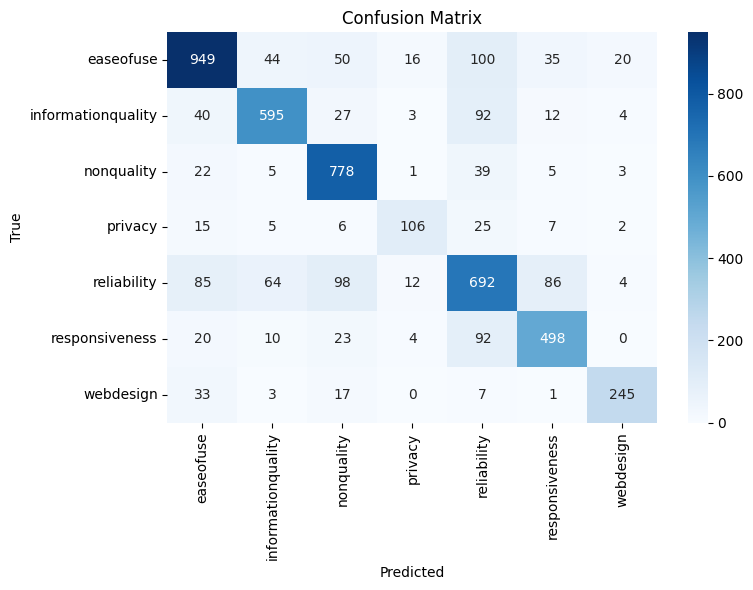

In [14]:
f1_scores = []
accuracies = []
precisions = []
recalls = []

# Tambahkan list untuk menyimpan semua y_test dan y_pred dari semua fold
all_y_true = []
all_y_pred = []

for i, (train_idx, test_idx) in enumerate(kf.split(X_tfidf, y), 1):
    X_train, X_test = X_tfidf[train_idx], X_tfidf[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Train SVM
    model = SVC(kernel='linear', class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    re = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"\n=== Fold {i} ===")
    print("Accuracy:", round(acc, 4))
    print("F1-score (macro):", round(f1, 4))
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    accuracies.append(acc)
    f1_scores.append(f1)
    precisions.append(prec)
    recalls.append(re)

    # ⬇ Simpan hasil prediksi dari fold ini
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# 5. Confusion Matrix GLOBAL (dari semua fold)
cm_global = confusion_matrix(all_y_true, all_y_pred)

# Plot Confusion Matrix Global
plt.figure(figsize=(8, 6))
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [15]:
# 5. Summary of all folds
print("\n=== RATA-RATA FOLD ===")
for i in range(len(accuracies)):
    print(f"Fold {i+1} - "
        f"Acc: {round(accuracies[i], 4)}, "
        f"Precision: {round(precisions[i], 4)}, "
        f"Recall: {round(recalls[i], 4)}, "
        f"F1: {round(f1_scores[i], 4)}")

print("\n=== RATA-RATA MATRIX ===")
print("Average Accuracy   :", round(np.mean(accuracies), 4))
print("Average Precision  :", round(np.mean(precisions), 4))
print("Average Recall     :", round(np.mean(recalls), 4))
print("Average F1-score   :", round(np.mean(f1_scores), 4))


=== RATA-RATA FOLD ===
Fold 1 - Acc: 0.768, Precision: 0.7916, Recall: 0.7553, F1: 0.7704
Fold 2 - Acc: 0.756, Precision: 0.7603, Recall: 0.7439, F1: 0.7502
Fold 3 - Acc: 0.783, Precision: 0.773, Recall: 0.7757, F1: 0.7731
Fold 4 - Acc: 0.776, Precision: 0.7874, Recall: 0.7589, F1: 0.7687
Fold 5 - Acc: 0.78, Precision: 0.7933, Recall: 0.7761, F1: 0.7831

=== RATA-RATA MATRIX ===
Average Accuracy   : 0.7726
Average Precision  : 0.7811
Average Recall     : 0.762
Average F1-score   : 0.7691


In [16]:
# 7. RATA-RATA PER LABEL (berdasarkan semua fold)
report = classification_report(all_y_true, all_y_pred, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_per_label = df_report.drop(["accuracy", "macro avg", "weighted avg"])

cm = confusion_matrix(all_y_true, all_y_pred)
label_counts = cm.sum(axis=1)  
correct_counts = np.diag(cm)   
accuracy_per_label = correct_counts / label_counts

df_per_label["accuracy"] = accuracy_per_label

print("\n=== RATA-RATA PER LABEL (Precision, Recall, F1-score, Accuracy) ===")
print(df_per_label[["precision", "recall", "f1-score", "accuracy"]])


=== RATA-RATA PER LABEL (Precision, Recall, F1-score, Accuracy) ===
                    precision    recall  f1-score  accuracy
easeofuse            0.815292  0.781713  0.798150  0.781713
informationquality   0.819559  0.769728  0.793863  0.769728
nonquality           0.778779  0.912075  0.840173  0.912075
privacy              0.746479  0.638554  0.688312  0.638554
reliability          0.660936  0.664745  0.662835  0.664745
responsiveness       0.773292  0.769706  0.771495  0.769706
webdesign            0.881295  0.800654  0.839041  0.800654
